# Synthesize 

Take the parsed, cleaned data, and synthesize a long-term daily record for the constituents
currently going into the model.

Specifically, this means
 - 2000 - 2016
 - NOx, NH3, OrthoP
 - False Delta sources, plus the 40+ discharges in the Bay.

In [20]:
from __future__ import print_function
import six
import pandas as pd

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import utils
import lp_filter
import glob
import os
from matplotlib import cm
import gmtColormap
%matplotlib notebook 

from ipywidgets import interactive
from IPython.display import display,HTML

In [21]:
compile_dir="../outputs/intermediate"
fig_dir="../outputs/figures"
output_dir="../outputs"

In [22]:
date_start=datetime.datetime(2000,1,1)
date_end  =datetime.datetime(2015,12,31)

dn_start=utils.to_dnum(date_start)
dn_end  =utils.to_dnum(date_end)

dns=np.arange(dn_start,dn_end+1)
fmt='%Y-%m-%d'
print("Generating daily data from %s to %s for %d time points"%(date_start.strftime(fmt),
                                                                date_end.strftime(fmt),
                                                                len(dns)))
ds=xr.Dataset()
ds['time']=utils.to_dt64(dns)
ds['dnum']=('time',dns)
ds=ds.set_coords('dnum')

analytes=['flow',
          'NOx_conc','NH3_conc','PO4_conc','Si_conc',
          'NOx_load','NH3_load','PO4_load','Si_load']

# These match the names of the CSV files
site_names=['tesoro','american','sasm','novato','sunnyvale',
            'petaluma','rodeo','fs','valero','phillips66',
            'vallejo','ebmud','san_mateo','sfo','palo_alto','sausalito',
            'south_bayside','ddsd','burlingame','pinole','st_helena',
            'yountville','benicia','millbrae','sonoma_valley','napa',
            'cccsd','ebda','calistoga','central_marin','lg','west_county_richmond',
            'chevron','sf_southeast','shell','mt_view','marin5','san_jose',
            'south_sf','ch','treasure_island','false_sj','false_sac' ]
ds['site']=( 'site', site_names)

# initialize full output array

for analyte in analytes:
    ds[analyte]=( ['time','site'],
             np.nan*np.ones( (len(ds.time),len(ds.site)) ) )

# set units for clarity upfront
ds.flow.attrs['units']='m3 s-1'

ds.NOx_conc.attrs['units']='mg/l N'
ds.NH3_conc.attrs['units']='mg/l N'
ds.PO4_conc.attrs['units']='mg/l P'
ds.Si_conc.attrs['units']='mg/l Si'
ds.NOx_load.attrs['units']='kg/day N'
ds.NH3_load.attrs['units']='kg/day N'
ds.PO4_load.attrs['units']='kg/day P'
ds.Si_load.attrs['units']='kg/day Si'

# setup flag entries
for v in ds.data_vars.keys():
    ds[v+'_flag']=( ds[v].dims, np.zeros(ds[v].shape,'i2'))
    ds[v].attrs['flags']=v+'_flag'

Generating daily data from 2000-01-01 to 2015-12-31 for 5844 time points


In [23]:
FLAG_LOADING_STUDY=1
FLAG_HDR=2
FLAG_SUMMER_ZERO=4
FLAG_SEASONAL_TREND=8
FLAG_INTERP=16
FLAG_MEAN=32
FLAG_CLIPPED=64 # this one actually does get used as a bitmask.

flag_bits=['LoadingStudy','HDR','Summer0','Trend','Interp','Mean','Clipped']

In [24]:
# Read in Loading Study data via one csv per site
for site in ds.site: 
    site=site.item() # get to a str object
    # site_idx=list(ds.site).index(site) # 11

    csv=pd.read_csv(os.path.join(compile_dir,site+'.csv'),
                        parse_dates=['Date'])
    csv_dnums=utils.to_dnum(csv.Date)
    csv_date_i = np.searchsorted(dns,csv_dnums)
 
    # limit to the overlap between csv dates and output dates
    date_valid=(csv_dnums>=dns[0]) & (csv_dnums<dns[-1])

    if 1: # FLOW
        if 'flow ft3/s' in csv:
            flow=0.028316847 * csv['flow ft3/s']
        elif 'flow mgd' in csv:
            flow=0.043812636 * csv['flow mgd']
        else:
            assert False
        valid=date_valid & ( ~flow.isnull().values)
        ds['flow'].sel(site=site)[csv_date_i[valid]] = flow[valid]
        ds['flow_flag'].sel(site=site)[csv_date_i[valid]]=FLAG_LOADING_STUDY
        flow_valid=valid # used below
        
    if 1: # NOx:
        nox=csv['NO3 mg/L N'].copy()
        try:
            nox += csv['NO2 mg/L N']
        except KeyError:
            print("No NO2 for %s - okay"%site)
        valid=date_valid & (~nox.isnull().values)

        ds['NOx_conc'].sel(site=site)[csv_date_i[valid]]=nox[valid]
        ds['NOx_conc_flag'].sel(site=site)[csv_date_i[valid]]=FLAG_LOADING_STUDY

        def conc_to_load(fld='NOx',flag=FLAG_LOADING_STUDY):
            flow_valid=ds['flow_flag'].sel(site=site).values==flag
            conc_valid=ds[fld+'_conc_flag'].sel(site=site).values==flag
            
            # and associated load:
            load_valid=conc_valid & flow_valid
            #     mg/L              m3/s
            load= (  ds[fld+'_conc'].sel(site=site).values[load_valid] 
                   * ds['flow'].sel(site=site).values[load_valid] )
            #   ...  L/m3   s/day   kg/mg  
            load *= 1e3  * 86400 * 1e-6
            ds[fld+'_load'].sel(site=site)[load_valid]=load
            ds[fld+'_load_flag'].sel(site=site)[load_valid]=flag
        conc_to_load('NOx',FLAG_LOADING_STUDY)
        
    if 1: # NH3
        nh3=csv['NH3 mg/L N']
        valid=date_valid & (~nh3.isnull().values)

        ds['NH3_conc'].sel(site=site)[csv_date_i[valid]]=nh3[valid]
        ds['NH3_conc_flag'].sel(site=site)[csv_date_i[valid]]=FLAG_LOADING_STUDY
        conc_to_load('NH3',FLAG_LOADING_STUDY)
        
    if 1: # PO4
        po4=csv['PO4 mg/L P']
        valid=date_valid & (~po4.isnull().values)

        ds['PO4_conc'].sel(site=site)[csv_date_i[valid]]=po4[valid]
        ds['PO4_conc_flag'].sel(site=site)[csv_date_i[valid]]=FLAG_LOADING_STUDY
        conc_to_load('PO4',FLAG_LOADING_STUDY)

No NO2 for false_sj - okay
No NO2 for false_sac - okay


In [25]:
def bin_mean(bins,values):
    sums=np.bincount(bins,weights=values)
    counts=np.bincount(bins)
    return sums/counts


def mark_gaps(dnums,valid,gap_days,yearday_start=-1,yearday_end=367,include_ends=False):
    """
    for a timeseries, assumed to be dense and daily,
    return a mask which is true for gaps in valid data
    which span at least gap_days, limited to the portion of 
    the year given by yearday_start,yearday_end.
    include_ends: include the possibility of a gap of gap_days//2 at the beginning
    and end of the series (i.e. as if the next valid data point were very far off
    the end of the series)
    """
    doy=np.array([d - utils.dnum_jday0(d)
                  for d in dnums] )

    missing=~valid
    in_window=(doy>=yearday_start)&(doy<yearday_end)
    present=np.nonzero( ~missing | ~in_window)[0]

    mask=np.zeros( len(dnums),np.bool )

    for gstart,gend in zip( present[:-1],present[1:] ):
        if gend-gstart<gap_days:
            continue
        mask[ gstart+gap_days//2 : gend-gap_days//2 ] = True
        
    if include_ends:
        # too tired to think through the logic of how the ends combined with
        # the yeardays.
        assert yearday_start<0
        assert yearday_end>366
        first_gap=max(0,present[0]-gap_days//2)
        mask[:first_gap]=True
        final_gap=min( len(mask), present[-1]+gap_days//2 )
        mask[final_gap:]=True
    return mask
    
def add_summer_noflow(site,gap_days=45,day_start=100,day_end=305):
    """ Designed for Napa, but possibly extend to others.
    Gaps of more than gap_days, which fall within the period
    dayofyear between [day_start,day_end] are filled with zero 
    flow.
    """
    gap_mask = mark_gaps(dns, 
                         np.isfinite( ds['flow'].sel(site=site).values ),
                         gap_days=gap_days,
                         yearday_start=day_start,
                         yearday_end=day_end)
    ds.flow.sel(site=site).values[gap_mask] = 0
    ds.flow_flag.sel(site=site).values[gap_mask] = FLAG_SUMMER_ZERO

In [26]:
# special handling of Napa with typically no flow in summer
add_summer_noflow(site='napa',gap_days=45,day_start=100,day_end=305)

In [27]:
# Load the HDR data in long format
hdr_fn=os.path.join(compile_dir,'hdr_parsed_long.csv')
hdr=pd.read_csv(hdr_fn)
month_starts=[ datetime.datetime(year=int(r.year),month=int(r.month),day=1)
               for ri,r in hdr.iterrows()]
hdr['dn_start']=utils.to_dnum( np.array(month_starts))
display(HTML('<h3>Peak at HDR Data</h3>'))
hdr.head()

,analyte,year,month,site,value,dn_start
0,flow_mgd,2012,7.0,San Pablo Bay,15.989105,734685.0
1,flow_mgd,2012,8.0,San Pablo Bay,15.852014,734716.0
2,flow_mgd,2012,9.0,San Pablo Bay,15.340764,734747.0
3,flow_mgd,2012,10.0,San Pablo Bay,21.317394,734777.0
4,flow_mgd,2012,11.0,San Pablo Bay,48.396282,734808.0


In [28]:
# bring in HDR data
sites=hdr.site.unique()
site_map=dict(zip(sites,[s.lower() for s in sites]))

In [29]:
site_map['American Canyon']='american'
site_map['CMSA']='central_marin'
site_map['Delta Diablo']='ddsd'
site_map['Fairfield-Suisun']='fs'
site_map['Las Gallinas']='lg'
site_map['Mt View']='mt_view'
site_map['Palo Alto']='palo_alto'
site_map['San Jose/Santa Clara']='san_jose'
site_map['San Mateo']='san_mateo'
site_map['SFO Airport']='sfo'
site_map['SFPUC Southeast Plant']='sf_southeast'
site_map['Sonoma Valley']='sonoma_valley'
site_map['South SF']='south_sf'
site_map['Treasure Island']='treasure_island'
site_map['West County']='west_county_richmond'
site_map['SVCW']='south_bayside' # silicon valley clean water - new name for south_bayside
site_map['SMCSD']= 'sausalito' # 
site_map['Crockett CSD Port Costa'] = 'ch' # right?

# These are in the HDR data, but ambiguous in the loading study:
#  Tiburon, Paradise Cove.  Both are ostensibly Marin SD 5.  Paradise Cove
#  has extremely small flows in the HDR data.  Tiburon is a good match for
#  the constant values in the Loading Study.
site_map['Tiburon'] = 'marin5'
# site_map['Paradise Cove']= 'marin5'# but Tiburon is also Marin SD 5...

# These are in the Loading study, but not HDR:
# refineries: tesoro, valero, phillips66, chevron, shell
# potws: st_helena, yountville, calistoga - all up Napa, right?
# false: false_sj, false_sac

unmapped = [site.item() for site in ds.site
            if site.item() not in site_map.values()]
print("Sites which had no HDR data: %s"%( ", ".join(unmapped) ))

Sites which had no HDR data: tesoro, valero, phillips66, st_helena, yountville, calistoga, chevron, shell, false_sj, false_sac


In [30]:
# Write out site_map so that the sidestream code can use the same mapping:
import pickle
with open('sites_hdr_to_local.pkl','wb') as fp:
    pickle.dump(site_map,fp)

pd.Series(site_map).to_csv('sites_hdr_to_local.csv')

In [31]:
for hdr_name,ls_name in six.iteritems(site_map):
    if ls_name not in list(ds.site.values):
        continue
    print( "%s => %s"%(hdr_name,ls_name))
    hdr_site = hdr[ hdr.site==hdr_name ]

    # move the analytes back to columns
    hdr_site = hdr_site.pivot(index='dn_start',columns='analyte',values='value').reset_index()
    dn_end=np.zeros(len(hdr_site.dn_start.values),'f8')
    dn_end[:-1]=hdr_site.dn_start.values[1:]
    dn_end[-1] = hdr_site.dn_start.values[-1] + 31
    hdr_site['dn_end']=dn_end
    hdr_site.head()

    for ri,r in hdr_site.iterrows():
        time_slc=slice(*np.searchsorted(ds.dnum,[r.dn_start,r.dn_end]))

        ds_site = ds.sel(site=site_map[hdr_name])

        def from_hdr(ds_fld,hdr_fld,factor=1):    
            ds_site[ds_fld].values[time_slc] = r[hdr_fld] * factor
            ds_site[ds_fld+'_flag'].values[time_slc] = FLAG_HDR

        # overwrite with HDR data, constant over month

        from_hdr('flow','flow_mgd',0.043812636)
        from_hdr('NOx_load','NOx_kgN_per_day',1)
        from_hdr('NH3_load','ammonia_kgN_per_day',1)
        # unclear whether we should go with diss_OrthoP, or total_kgP ...
        from_hdr('PO4_load','diss_OrthoP_kgP_per_day')

        # and the conversion to conc:
        def to_conc(ds_fld):
            flow = ds_site['flow'].values[time_slc] # m3/s
            load = ds_site[ds_fld+'_load'].values[time_slc] # kg X / day
            # convert to g/m3
            conc = (load * 1000) / (flow*86400)
            conc[ flow==0.0] = 0.0
            #    (kgX/d) * g/kg / (m3/s * s/day) => gX / m3
            ds_site[ds_fld+'_conc'].values[time_slc] = conc
            ds_site[ds_fld+'_conc_flag'].values[time_slc] = FLAG_HDR

        to_conc('NOx')
        to_conc('NH3')
        to_conc('PO4')


Vallejo => vallejo
CMSA => central_marin
Novato => novato
South SF => south_sf
Millbrae => millbrae
West County => west_county_richmond
Burlingame => burlingame
Las Gallinas => lg
SFPUC Southeast Plant => sf_southeast
Crockett CSD Port Costa => ch
Napa => napa
CCCSD => cccsd
Pinole => pinole
American Canyon => american
SFO Airport => sfo
Sunnyvale => sunnyvale
SMCSD => sausalito
Petaluma => petaluma
Benicia => benicia
Fairfield-Suisun => fs
Sonoma Valley => sonoma_valley
Mt View => mt_view
Treasure Island => treasure_island
San Mateo => san_mateo
SVCW => south_bayside
EBMUD => ebmud
EBDA => ebda
Delta Diablo => ddsd
Rodeo => rodeo
San Jose/Santa Clara => san_jose
Tiburon => marin5
SASM => sasm
Palo Alto => palo_alto


In [32]:
# The interpolation step - building off of synth_v02.py

fields=[s for s in ds.data_vars if not s.endswith('_flag')]

lowpass_days=3*365
shortgap_days=45 # okay to interpolate a little over a month?

# first, create mapping from time index to absolute month
dts=utils.to_datetime(dns)
absmonth = [12*dt.year + (dt.month-1) for dt in dts]
absmonth = np.array(absmonth) - dts[0].year*12
month=absmonth%12


for site in ds.site.values:
    print("Site: %s"%site)
    for fld in fields: 
        fld_in=ds[fld].sel(site=site)
        orig_values=fld_in.values
        fld_flag=ds[fld+'_flag'].sel(site=site)

        prefilled=fld_flag.values & (FLAG_SEASONAL_TREND | FLAG_INTERP | FLAG_MEAN)        
        fld_in.values[prefilled]=np.nan # resets the work of this loop in case it's run multiple times
        n_valid=np.sum( ~fld_in.isnull())        
        
        if n_valid==0:
            msg=" --SKIPPING--"
        else:
            msg=""
        print("   field: %s  %d/%d valid input points %s"%(fld,n_valid,len(fld_in),msg))

        if n_valid==0:
            continue
            
        # get the data into a monthly time series before trying to fit seasonal cycle
        valid = np.isfinite(fld_in.values)
        absmonth_mean=bin_mean(absmonth[valid],fld_in.values[valid])
        month_mean=bin_mean(month[valid],fld_in.values[valid])
        
        if np.sum(np.isfinite(month_mean)) < 12:
            print("Insufficient data for seasonal trends - will fill with sample mean")
            trend_and_season=np.nanmean(month_mean) * np.ones(len(dns))
            t_and_s_flag=FLAG_MEAN
        else:
            # fit long-term trend and a stationary seasonal cycle
            # this removes both the seasonal cycle and the long-term mean,
            # leaving just the trend
            trend_hf=fld_in.values - month_mean[month]
            lp = lp_filter.lowpass_fir(trend_hf,lowpass_days,nan_weight_threshold=0.01)
            trend = utils.fill_invalid(lp)
            # recombine with the long-term mean and monthly trend 
            # to get the fill values.
            trend_and_season = trend + month_mean[month]
            t_and_s_flag=FLAG_SEASONAL_TREND

        # long gaps are mostly filled by trend and season
        gaps=mark_gaps(dns,valid,shortgap_days,include_ends=True) 
        fld_in.values[gaps] = trend_and_season[gaps]
        fld_flag.values[gaps] = t_and_s_flag

        still_missing=np.isnan(fld_in.values)
        fld_in.values[still_missing] = utils.fill_invalid(fld_in.values)[still_missing]
        fld_flag.values[still_missing] = FLAG_INTERP

        # Make sure all flows are nonnegative
        negative=fld_in.values<0.0
        fld_in.values[negative]=0.0
        fld_flag.values[negative] |= FLAG_CLIPPED
        if 0: # illustrative plots
            fig,ax=plt.subplots()
            ax.plot(dns,orig_values,'m-o',label='Measured %s'%fld)
            ax.plot(dns,fld_in,'k-',label='Final %s'%fld,zorder=5)
            # ax.plot(dns,month_mean[month],'r-',label='Monthly Clim.')
            # ax.plot(dns,trend_hf,'b-',label='Trend w/HF')
            ax.plot(dns,trend,'g-',lw=3,label='Trend')
            ax.plot(dns,trend_and_season,color='orange',label='Trend and season')


Site: tesoro
   field: flow  3988/5844 valid input points 
   field: NOx_conc  28/5844 valid input points 
   field: NH3_conc  192/5844 valid input points 
   field: PO4_conc  3959/5844 valid input points 
   field: Si_conc  0/5844 valid input points  --SKIPPING--
   field: NOx_load  28/5844 valid input points 
   field: NH3_load  192/5844 valid input points 
   field: PO4_load  3959/5844 valid input points 
   field: Si_load  0/5844 valid input points  --SKIPPING--
Site: american
   field: flow  1423/5844 valid input points 
   field: NOx_conc  973/5844 valid input points 
   field: NH3_conc  1117/5844 valid input points 
   field: PO4_conc  1117/5844 valid input points 
   field: Si_conc  0/5844 valid input points  --SKIPPING--
   field: NOx_load  973/5844 valid input points 
   field: NH3_load  1117/5844 valid input points 
   field: PO4_load  1117/5844 valid input points 
   field: Si_load  0/5844 valid input points  --SKIPPING--
Site: sasm
   field: flow  1423/5844 valid input poi

<IPython.core.display.Javascript object>


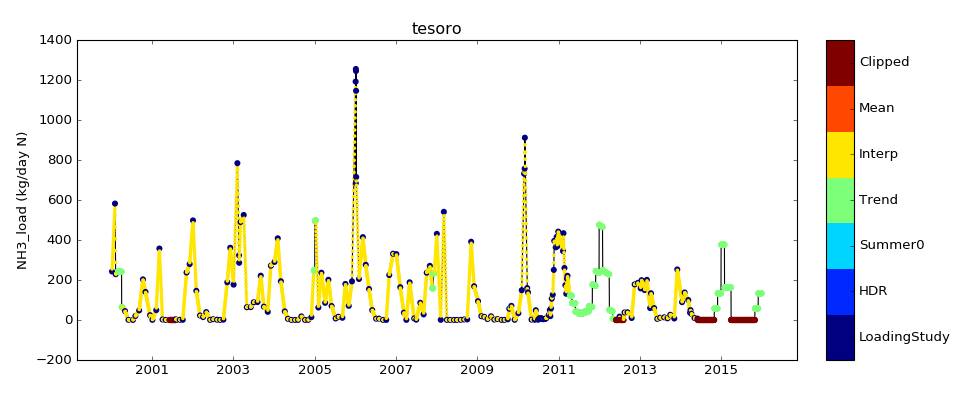

In [33]:
# build up a little dashboard to see what we've got so far:
sites=list(ds.site.values)
plot_vars=[s for s in ds.data_vars if not s.endswith('_flag')]
plot_vars

fig,ax=plt.subplots(1,1,figsize=(12,5))
cax=fig.add_axes([0.86,0.1,0.03,0.8])
fig.subplots_adjust(left=0.08,right=0.83)

cmap=gmtColormap.cmap_discretize(cm.jet,7)

def update_plot(site,plot_var):    
    ax.cla()
    cax.cla()
    
    values=ds[plot_var].sel(site=site).values
    if ~np.any( np.isfinite(values)):
        print("No data")
        return False
    ax.plot(ds.time,
            ds[plot_var].sel(site=site),'k-')
    flags=ds[plot_var+'_flag'].sel(site=site).values
          
    sizes=np.ones(ds.time.values.shape) * 30
    sizes[flags==FLAG_INTERP]=10
    coll = ax.scatter(ds.time.values,
                      ds[plot_var].sel(site=site).values,
                      sizes,
                      np.log2(flags.clip(1,np.inf)),
                      cmap=cmap,
                      lw=0,zorder=5,vmin=np.log2(1)-0.5,vmax=np.log2(64)+0.5)
    ax.set_ylabel("%s (%s)"%(plot_var,ds[plot_var].attrs['units']))
    ax.set_title(site)
    
    cbar=plt.colorbar(coll,cax=cax)
    flag_values=np.array([1,2,4,8,16,32,64])
    flag_pvalues=np.log2(flag_values)
    cbar.set_ticks(flag_pvalues)
    cbar.set_ticklabels(flag_bits)
    plt.draw()
    return True
    
site='ebmud'
plot_var='flow'
update_plot(site='ebmud',plot_var='flow')
gui=interactive(update_plot,site=sites,plot_var=plot_vars)

In [34]:
gui

True

In [277]:
# Auto-generate the full set:
if 1: 
    os.path.exists(fig_dir) or os.mkdir(fig_dir)
    for site in sites:
        
        for plot_var in plot_vars:
            if plot_var=='site_type':
                continue
            print("%s, %s"%(site,plot_var))
            if update_plot(site=site,plot_var=plot_var):
                fig.savefig(os.path.join(fig_dir,"full_series-%s-%s.png"%(site,plot_var)),dpi=90)

tesoro, flow
tesoro, NOx_conc
tesoro, NH3_conc
tesoro, PO4_conc
tesoro, Si_conc
No data
tesoro, NOx_load
tesoro, NH3_load
tesoro, PO4_load
tesoro, Si_load
No data
american, flow
american, NOx_conc
american, NH3_conc
american, PO4_conc
american, Si_conc
No data
american, NOx_load
american, NH3_load
american, PO4_load
american, Si_load
No data
sasm, flow
sasm, NOx_conc
sasm, NH3_conc
sasm, PO4_conc
sasm, Si_conc
No data
sasm, NOx_load
sasm, NH3_load
sasm, PO4_load
sasm, Si_load
No data
novato, flow
novato, NOx_conc
novato, NH3_conc
novato, PO4_conc
novato, Si_conc
No data
novato, NOx_load
novato, NH3_load
novato, PO4_load
novato, Si_load
No data
sunnyvale, flow
sunnyvale, NOx_conc
sunnyvale, NH3_conc
sunnyvale, PO4_conc
sunnyvale, Si_conc
No data
sunnyvale, NOx_load
sunnyvale, NH3_load
sunnyvale, PO4_load
sunnyvale, Si_load
No data
petaluma, flow
petaluma, NOx_conc
petaluma, NH3_conc
petaluma, PO4_conc
petaluma, Si_conc
No data
petaluma, NOx_load
petaluma, NH3_load
petaluma, PO4_load
pet

Issues so far:
Flow:
 - american: the old assumption of zero Jun-Nov, 0.12 the rest of the time, is not really born out by the HDR data.  Should we abandon the loading study approach, and just use HDR as a seasonal for the whole time?
 - sasm: has a long period of constant flow from the loading study - but right now we fill gaps in.  
 - novato: has some monthly data which maybe should be interpolated at larger time scales than 10 days.  also why is the seasonal signal absent for the first stretch?
 

In [41]:
# Mark the "types" of the sites (false, potw, refinery)
ds['site_type']=('site',[' '*20]*len(ds.site.values))

for s in ['tesoro','phillips66','valero','chevron','shell']:
    ds.site_type.loc[s] = 'refinery'
for s in ['american','sasm','novato','sunnyvale','petaluma',
          'rodeo','fs','vallejo','ebmud','san_mateo','sfo',
          'palo_alto','sausalito','south_bayside','ddsd',
          'burlingame','pinole','st_helena','yountville',
          'benicia','millbrae','sonoma_valley','napa','cccsd',
          'ebda','calistoga','central_marin','lg','west_county_richmond',
          'sf_southeast','mt_view','marin5','san_jose',
          'south_sf','ch','treasure_island']:
    ds.site_type.loc[s] = 'potw'
for s in ['false_sac','false_sj']:
    ds.site_type.loc[s] = 'false'

for st in np.unique( ds.site_type.values ):
    count =np.sum(ds.site_type==st)
    print("Site type %s: %d"%(st,count))

Site type false: 2
Site type potw: 36
Site type refinery: 5


In [42]:
# Still need lat/lon...
ds.to_netcdf(os.path.join( output_dir,'sfbay_potw.nc'))

In [43]:
!md5sum ../outputs/sfbay_potw.nc


e1c877d3656edd6ecc6f2b362ab6aa5e  ../outputs/sfbay_potw.nc


In [35]:
# tracking down issues with tesoro...
ds['NH3_load'].sel(site='tesoro')

<xarray.DataArray 'NH3_load' (time: 5844)>
array([ 242.75845555,  242.75845555,  242.75845555, ...,  133.64538629,
        133.64538629,  133.64538629])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
    dnum     (time) float64 7.301e+05 7.301e+05 7.301e+05 7.301e+05 ...
    site     <U20 'tesoro'
Attributes:
    units: kg/day N
    flags: NH3_load_flag

Site: american
   field: NOx_conc  5841/5844 valid input points 


<IPython.core.display.Javascript object>


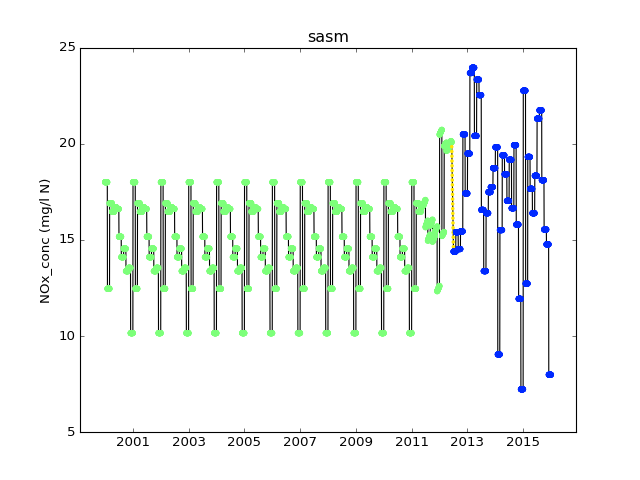

In [282]:
# poking around some details of nutrient extrapolation
# The interpolation step - building off of synth_v02.py

fields=[s for s in ds.data_vars if not s.endswith('_flag')]

lowpass_days=3*365
shortgap_days=45 # okay to interpolate a little over a month?

# first, create mapping from time index to absolute month
dts=utils.to_datetime(dns)
absmonth = [12*dt.year + (dt.month-1) for dt in dts]
absmonth = np.array(absmonth) - dts[0].year*12
month=absmonth%12


for site in ['american']: # ds.site.values:
    print("Site: %s"%site)
    for fld in ['NOx_conc']: # fields: 
        fld_in=ds[fld].sel(site=site)
        orig_values=fld_in.values
        fld_flag=ds[fld+'_flag'].sel(site=site)

        prefilled=fld_flag.values & (FLAG_SEASONAL_TREND | FLAG_INTERP | FLAG_MEAN)        
        fld_in.values[prefilled]=np.nan # resets the work of this loop in case it's run multiple times
        n_valid=np.sum( np.isfinite(fld_in.values) )        
        
        if n_valid==0:
            msg=" --SKIPPING--"
        else:
            msg=""
        print("   field: %s  %d/%d valid input points %s"%(fld,n_valid,len(fld_in),msg))

        if n_valid==0:
            continue
            
        # get the data into a monthly time series before trying to fit seasonal cycle
        valid = np.isfinite(fld_in.values)
        absmonth_mean=bin_mean(absmonth[valid],fld_in.values[valid])
        month_mean=bin_mean(month[valid],fld_in.values[valid])
        
        if np.sum(np.isfinite(month_mean)) < 12:
            print("Insufficient data for seasonal trends - will fill with sample mean")
            trend_and_season=np.nanmean(month_mean) * np.ones(len(dns))
            t_and_s_flag=FLAG_MEAN
        else:
            # fit long-term trend and a stationary seasonal cycle
            # this removes both the seasonal cycle and the long-term mean,
            # leaving just the trend
            trend_hf=fld_in.values - month_mean[month]
            lp = lp_filter.lowpass_fir(trend_hf,lowpass_days,nan_weight_threshold=0.01)
            trend = utils.fill_invalid(lp)
            # recombine with the long-term mean and monthly trend 
            # to get the fill values.
            trend_and_season = trend + month_mean[month]
            t_and_s_flag=FLAG_SEASONAL_TREND

        # long gaps are mostly filled by trend and season
        gaps=mark_gaps(dns,valid,shortgap_days,include_ends=True) 
        fld_in.values[gaps] = trend_and_season[gaps]
        fld_flag.values[gaps] = t_and_s_flag

        still_missing=np.isnan(fld_in.values)
        fld_in.values[still_missing] = utils.fill_invalid(fld_in.values)[still_missing]
        fld_flag.values[still_missing] = FLAG_INTERP

        # Make sure all flows are nonnegative
        negative=fld_in.values<0.0
        fld_in.values[negative]=0.0
        fld_flag.values[negative] |= FLAG_CLIPPED
        if 1: # illustrative plots
            fig,ax=plt.subplots()
            ax.plot(dns,orig_values,'m-o',label='Measured %s'%fld)
            ax.plot(dns,fld_in,'k-',label='Final %s'%fld,zorder=5)
            # ax.plot(dns,month_mean[month],'r-',label='Monthly Clim.')
            # ax.plot(dns,trend_hf,'b-',label='Trend w/HF')
            ax.plot(dns,trend,'g-',lw=3,label='Trend')
            ax.plot(dns,trend_and_season,color='orange',label='Trend and season')

In [298]:
str(name.values)

'false_sac'

<IPython.core.display.Javascript object>


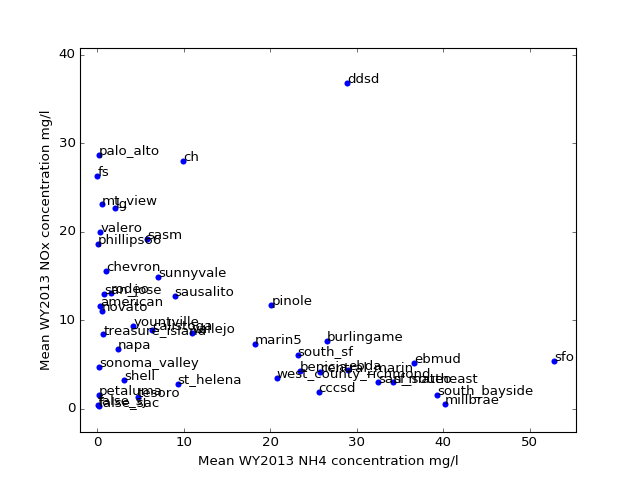

In [302]:
time_sel = (ds.time>= np.datetime64('2012-09-01 00:00')) & (ds.time<=np.datetime64('2013-10-01 00:00'))
time_sel=time_sel.values

ds2013=ds.isel(time=time_sel)

net_flow=ds2013.flow.sum(dim='time')
site_nh4=(ds2013.NH3_conc*ds2013.flow).sum(dim='time') / net_flow
site_no3=(ds2013.NOx_conc*ds2013.flow).sum(dim='time') / net_flow

fig,ax=plt.subplots()

ax.scatter( site_nh4, site_no3,30,lw=0)

for i,name in enumerate(ds2013.site):
    ax.text( site_nh4.values[i],
             site_no3.values[i],
           str(name.values))
    
ax.set_xlabel('Mean WY2013 NH4 concentration mg/l')
ax.set_ylabel('Mean WY2013 NOx concentration mg/l')

In [338]:
# Scatter of average NO3 and NH4
# july 2011 - june 2014
#sel=( (ds.time>np.datetime64('2011-07-01 00:00')) & (ds.time<np.datetime64('2014-06-30 00:00'))).values

sel=( (ds.time>np.datetime64('2015-07-01 00:00')) & (ds.time<np.datetime64('2015-08-01 00:00'))).values
ds.NH3_load.sel(site='ebmud').isel(time=sel).mean() * 2.2 # 17318 lb N / day

<xarray.DataArray 'NH3_load' ()>
array(18882.527472908005)
Coordinates:
    site     <U5 'ebmud'